<a href="https://colab.research.google.com/github/aissatou02/serverDataIA2/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc


In [3]:
#Chargement du fichier csv
df = pd.read_csv("/content/bienetre.csv")


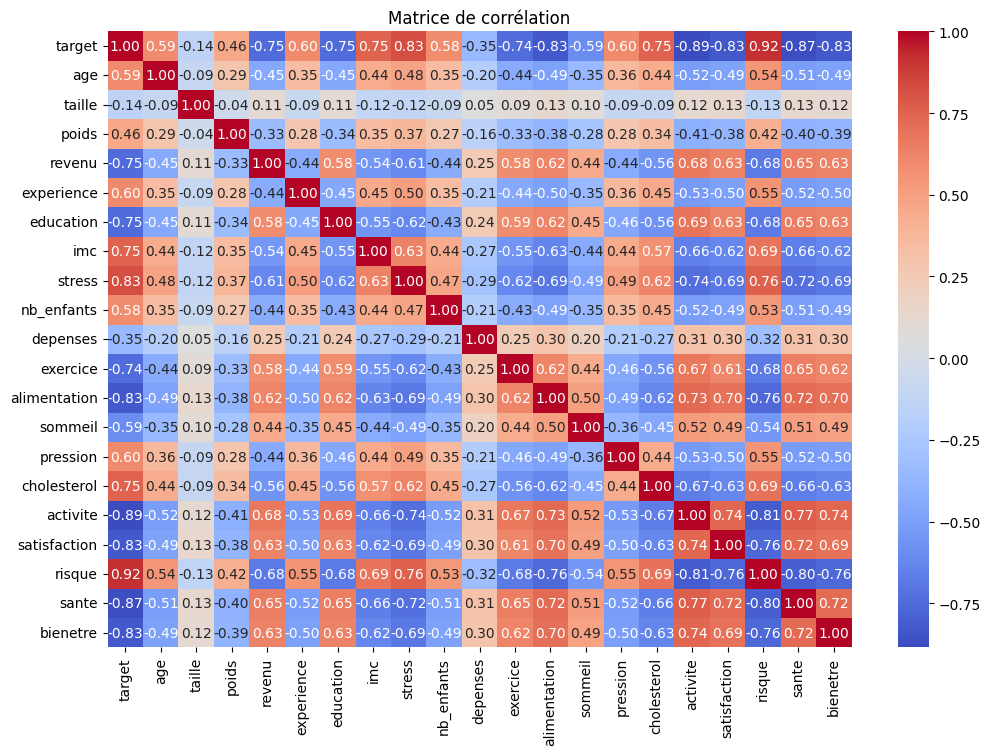

In [4]:
#Création de la matrice de corrélation pour voir la liaisons des variables entre elles et voir si on doit en supprimer certains oubien les combiner
plt.figure(figsize=(12, 8))  #j'agrandit la taille pour avoir une meilleure visualisation de ma matrice
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matrice de corrélation")
plt.show()

In [5]:
X = df.drop(columns=["target"])  #j'enlève "target" parce que c'est ma cible et c'est celle que je veux prédire
y = df["target"]


In [6]:
# Normalisation des données :
#je vais appliquer un StandardScaler pour la normalisation car certains algorithme comme le KNN et le PCA sont sensibles à une variation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
#Alors là on réduit la dimension avec le PCA qui permet de modifier la complexité , les dimensions mais tout en gardant les informations essentiels
#D'abord en 2D
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

In [8]:
# Maintenant en 3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)


In [9]:
# PCA pour conserver 95% de la variance cumulative, ce qui permet de réduire la dimension tout en gardant une grande partie de l'information
# C'est super utile car cela réduit la complexité du modèle tout en préservant les caractéristiques importantes des données
pca_95 = PCA(n_components=0.95) #On conserve l'essentiem
X_pca_95 = pca_95.fit_transform(X_scaled)


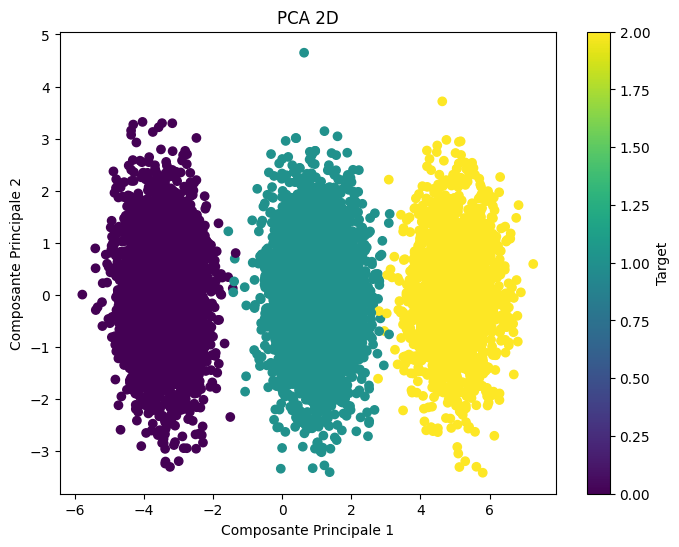

In [36]:
# Visualisation en 2D avec les 2 premières composantes principales
# C'est intéressant car cela permet de voir si les données sont séparées ou groupées de manière significative après réduction de dimension
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap='viridis')  # J'affiche les points en 2D avec une couleur différente pour chaque classe
plt.title('PCA 2D')  # Je donne un titre à la visualisation
plt.xlabel('Composante Principale 1')  # Je nomme les axes selon les composantes principales
plt.ylabel('Composante Principale 2')
plt.colorbar(label='Target')  # Ajoute une légende pour expliquer les couleurs
plt.show()  # Affichage du graphique

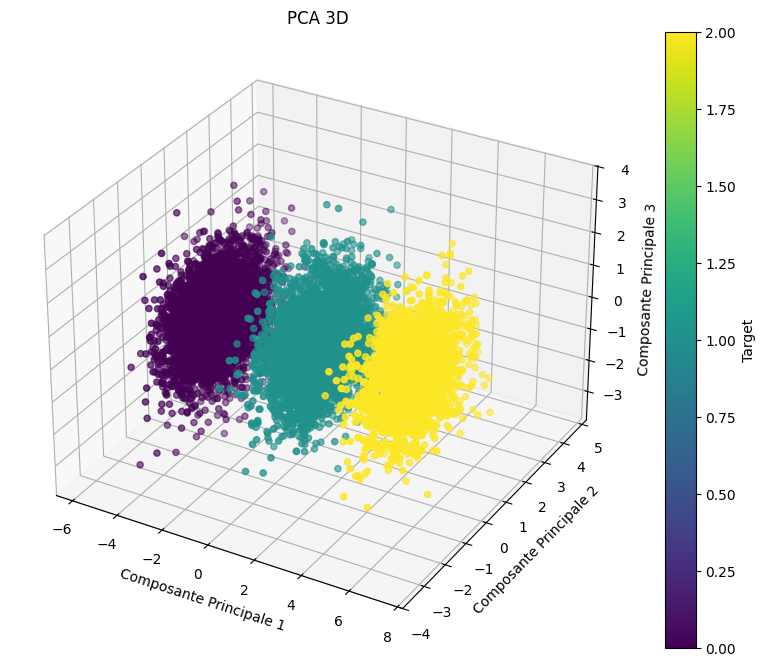

In [14]:
# Visualisation en 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=y, cmap='viridis')
ax.set_xlabel('Composante Principale 1')
ax.set_ylabel('Composante Principale 2')
ax.set_zlabel('Composante Principale 3')
fig.colorbar(scatter, label='Target')
plt.title('PCA 3D')
plt.show()


In [15]:
# Maintenant je fais une régression logistique pour prédire la target à partir des données  normaliséesen utilisant la validation croisée  pour éviter le surapprentissage
log_reg = LogisticRegression()
cv_scores = cross_val_score(log_reg, X_scaled, y, cv=5)
print("Régression Logistique - Score Cross Validation (normalisé) :", np.mean(cv_scores))


Régression Logistique - Score Cross Validation (normalisé) : 0.9997


In [16]:
# Maintenant je fais la régression logistique sur les données après réduction de dimension avec PCA (2D)
# Cela permet de voir si la réduction de dimension aide à mieux prédire la target ou non
cv_scores_pca_2d = cross_val_score(log_reg, X_pca_2d, y, cv=5)
print("Régression Logistique - Score Cross Validation (PCA 2D) :", np.mean(cv_scores_pca_2d))


Régression Logistique - Score Cross Validation (PCA 2D) : 0.9986


In [17]:
# Pareil en 3D
cv_scores_pca_3d = cross_val_score(log_reg, X_pca_3d, y, cv=5)
print("Régression Logistique - Score Cross Validation (PCA 3D) :", np.mean(cv_scores_pca_3d))


Régression Logistique - Score Cross Validation (PCA 3D) : 0.9986


In [18]:
#avec les données réduites à 95% de la variance
cv_scores_pca_95 = cross_val_score(log_reg, X_pca_95, y, cv=5)
print("Régression Logistique - Score Cross Validation (PCA 95%) :", np.mean(cv_scores_pca_95))


Régression Logistique - Score Cross Validation (PCA 95%) : 0.9995


In [19]:
# Calcul de la courbe ROC pour évaluer la performance de la régression logistique
# La courbe ROC nous aide à comprendre la performance du modèle en fonction des faux positifs et vrais positifs
log_reg.fit(X_scaled, y)
y_probs = log_reg.predict_proba(X_scaled)[:, 1]  # Probabilité pour la classe 'À Risque'
fpr, tpr, _ = roc_curve(y, y_probs, pos_label="À Risque")
roc_auc = auc(fpr, tpr)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


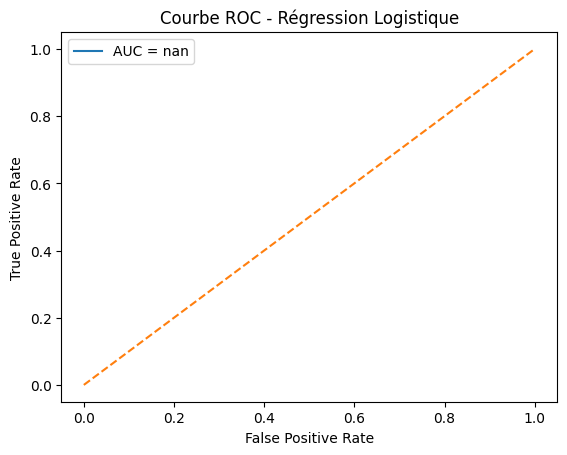

In [20]:
# Visualisation de la courbe ROC
plt.figure()
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))  # Affichage de la courbe ROC
plt.plot([0, 1], [0, 1], linestyle='--')  # Ligne de référence pour un modèle aléatoire
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC - Régression Logistique')
plt.legend()
plt.show()

In [21]:
# KNN avec recherche du meilleur K
# On va utiliser GridSearchCV pour tester différents K (nombre de voisins) et trouver celui qui donne les meilleures performances
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1, 20)}  # Recherche du meilleur K entre 1 et 20
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_scaled, y)
print("K optimal pour KNN (donnée normalisée) :", grid_search.best_params_["n_neighbors"])


K optimal pour KNN (donnée normalisée) : 17


In [22]:
#on fait pareil avec les données PCA en 2D
grid_search_pca_2d = GridSearchCV(knn, param_grid, cv=5)
grid_search_pca_2d.fit(X_pca_2d, y)
print("K optimal pour KNN (PCA 2D) :", grid_search_pca_2d.best_params_["n_neighbors"])


K optimal pour KNN (PCA 2D) : 18


In [23]:
#pour les données en 3D
grid_search_pca_3d = GridSearchCV(knn, param_grid, cv=5)
grid_search_pca_3d.fit(X_pca_3d, y)
print("K optimal pour KNN (PCA 3D) :", grid_search_pca_3d.best_params_["n_neighbors"])


K optimal pour KNN (PCA 3D) : 7


In [24]:
# KNN avec PCA 95% de la variance conservée
grid_search_pca_95 = GridSearchCV(knn, param_grid, cv=5)
grid_search_pca_95.fit(X_pca_95, y)
print("K optimal pour KNN (PCA 95%) :", grid_search_pca_95.best_params_["n_neighbors"])


K optimal pour KNN (PCA 95%) : 9


In [25]:
# Recherche des meilleurs paramètres pour l'arbre de décision (profondeur maximale et taille minimale des feuilles)
# L'arbre de décision peut être sensible à ces paramètres, donc il est important de les ajuster pour éviter un surapprentissage
dt = DecisionTreeClassifier()
param_grid_dt = {'max_depth': range(1, 20), 'min_samples_leaf': range(1, 10)}  # Plage pour la profondeur et taille des feuilles
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5)
grid_search_dt.fit(X_scaled, y)
print("Meilleurs paramètres pour l'arbre de décision :", grid_search_dt.best_params_)

Meilleurs paramètres pour l'arbre de décision : {'max_depth': 10, 'min_samples_leaf': 1}


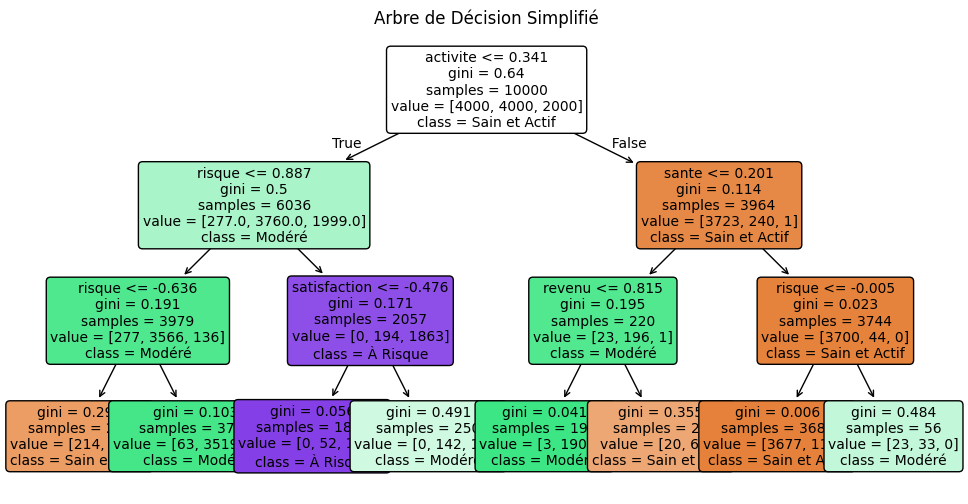

In [37]:
from sklearn.tree import plot_tree

# Entraîner un arbre de décision avec des paramètres plus simples
simple_dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)  # Réduction de la complexité
simple_dt.fit(X_scaled, y)

# Visualisation de l'arbre de décision simplifié
plt.figure(figsize=(12, 6))
plot_tree(simple_dt, feature_names=df.drop(columns=['target']).columns,
          class_names=['Sain et Actif', 'Modéré', 'À Risque'],
          filled=True, rounded=True, fontsize=10)
plt.title("Arbre de Décision Simplifié")
plt.show()


In [38]:
print("Meilleurs paramètres pour l'arbre de décision :", grid_search_dt.best_params_)


Meilleurs paramètres pour l'arbre de décision : {'max_depth': 10, 'min_samples_leaf': 1}
